#Dataset Retinopathy Preprocessing

done by : ELGARCH Youssef and IBNOU-KADY Nisirne

In [1]:
# ========== CELL 1: Install Dependencies ==========
!pip install opencv-python-headless
!pip install scikit-learn
!pip install seaborn
!pip install plotly
!pip install Pillow
!pip install albumentations

import warnings
warnings.filterwarnings('ignore')
print("✅ All dependencies installed successfully!")
print("🔬 Welcome to Advanced Diabetic Retinopathy Dataset Preprocessing Pipeline")
print("📊 This notebook will process your dataset and show visual outputs for each technique")

✅ All dependencies installed successfully!
🔬 Welcome to Advanced Diabetic Retinopathy Dataset Preprocessing Pipeline
📊 This notebook will process your dataset and show visual outputs for each technique


In [2]:
# ========== CELL 2: Import All Libraries ==========
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ExifTags, ImageFilter
import seaborn as sns
from google.colab import files, drive
import shutil
from collections import Counter
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from pathlib import Path
import albumentations as A

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("📁 Ready to process diabetic retinopathy images with advanced techniques")

✅ All libraries imported successfully!
📁 Ready to process diabetic retinopathy images with advanced techniques


📁 Please upload your diabetic retinopathy dataset zip file:


Saving Retinopathy (1).zip to Retinopathy (1).zip
📦 Extracting Retinopathy (1).zip...
✅ Dataset extracted successfully!
🔍 Found 2838 images in the dataset
📸 Sample images from your dataset:


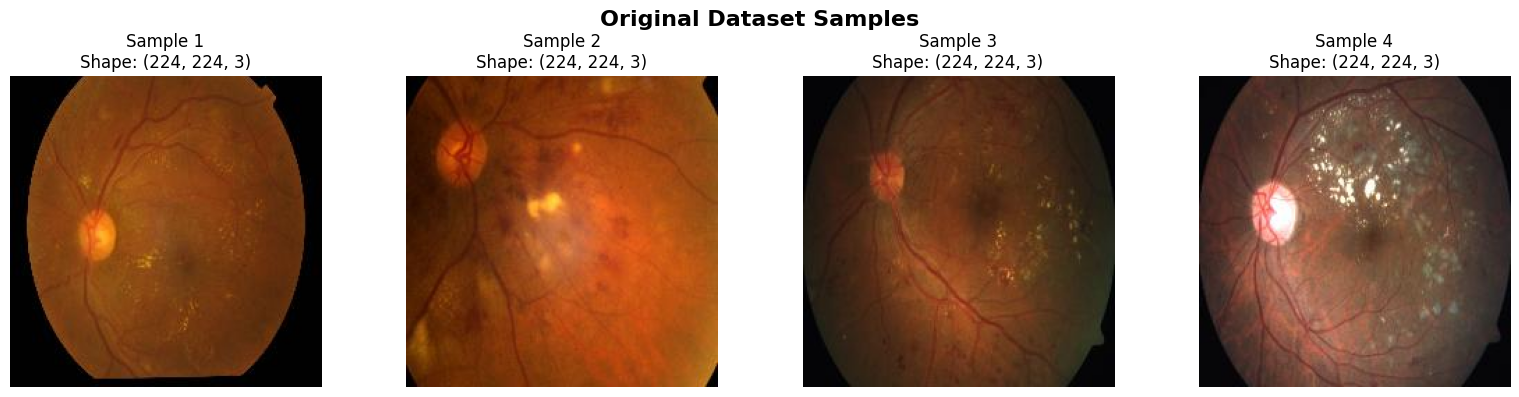

In [3]:


# ========== CELL 4: Upload and Extract Dataset ==========
print("📁 Please upload your diabetic retinopathy dataset zip file:")
uploaded = files.upload()

zip_filename = list(uploaded.keys())[0]
print(f"📦 Extracting {zip_filename}...")

# Create base directories
base_dir = '/content/diabetic_retinopathy_dataset'
os.makedirs(base_dir, exist_ok=True)

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(base_dir)

print("✅ Dataset extracted successfully!")

# Scan and organize initial dataset
def scan_dataset(base_path):
    """Scan the dataset and return image paths and basic info"""
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    image_paths = []

    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_paths.append(os.path.join(root, file))

    return image_paths

original_images = scan_dataset(base_dir)
print(f"🔍 Found {len(original_images)} images in the dataset")

# Show first few sample images
if len(original_images) > 0:
    print("📸 Sample images from your dataset:")
    fig, axes = plt.subplots(1, min(4, len(original_images)), figsize=(16, 4))
    if len(original_images) == 1:
        axes = [axes]

    for i in range(min(4, len(original_images))):
        img = cv2.imread(original_images[i])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if len(original_images) > 1:
            axes[i].imshow(img_rgb)
            axes[i].set_title(f'Sample {i+1}\nShape: {img_rgb.shape}')
            axes[i].axis('off')
        else:
            axes.imshow(img_rgb)
            axes.set_title(f'Sample Image\nShape: {img_rgb.shape}')
            axes.axis('off')

    plt.suptitle('Original Dataset Samples', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [4]:
# ========== CELL 5: Create Processing Directories Structure ==========
# Create comprehensive directory structure for all preprocessing techniques
processing_dirs = {
    'original': '/content/processed_dataset/01_original',
    'contrast_enhanced': '/content/processed_dataset/02_contrast_enhanced',
    'grayscale': '/content/processed_dataset/03_grayscale',
    'clahe_enhanced': '/content/processed_dataset/04_clahe_enhanced',
    'gaussian_blur': '/content/processed_dataset/05_gaussian_blur',
    'edge_detection': '/content/processed_dataset/06_edge_detection',
    'histogram_equalized': '/content/processed_dataset/07_histogram_equalized',
    'normalized': '/content/processed_dataset/08_normalized',
    'cropped_retina': '/content/processed_dataset/09_cropped_retina',
    'augmented': '/content/processed_dataset/10_augmented',
    'vessel_enhanced': '/content/processed_dataset/11_vessel_enhanced',
    'noise_reduced': '/content/processed_dataset/12_noise_reduced'
}

# Create train/val/test subdirectories for each processing type
for process_name, process_dir in processing_dirs.items():
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(process_dir, split), exist_ok=True)

print("✅ Processing directory structure created!")
print("📁 Created directories for:")
for name, path in processing_dirs.items():
    print(f"   • {name}: {path}")

✅ Processing directory structure created!
📁 Created directories for:
   • original: /content/processed_dataset/01_original
   • contrast_enhanced: /content/processed_dataset/02_contrast_enhanced
   • grayscale: /content/processed_dataset/03_grayscale
   • clahe_enhanced: /content/processed_dataset/04_clahe_enhanced
   • gaussian_blur: /content/processed_dataset/05_gaussian_blur
   • edge_detection: /content/processed_dataset/06_edge_detection
   • histogram_equalized: /content/processed_dataset/07_histogram_equalized
   • normalized: /content/processed_dataset/08_normalized
   • cropped_retina: /content/processed_dataset/09_cropped_retina
   • augmented: /content/processed_dataset/10_augmented
   • vessel_enhanced: /content/processed_dataset/11_vessel_enhanced
   • noise_reduced: /content/processed_dataset/12_noise_reduced


In [5]:
# ========== CELL 6: Advanced Image Preprocessing Functions ==========
class DiabeticsPreprocessor:
    """Advanced preprocessing class for diabetic retinopathy images"""

    def __init__(self):
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    def crop_retina_region(self, image, tol=7):
        """Crop to focus on retinal area by removing black borders"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image.copy()

        # Find the retinal area
        mask = gray > tol
        coords = np.argwhere(mask)

        if len(coords) > 0:
            y0, x0 = coords.min(axis=0)
            y1, x1 = coords.max(axis=0) + 1

            if len(image.shape) == 3:
                cropped = image[y0:y1, x0:x1]
            else:
                cropped = image[y0:y1, x0:x1]
        else:
            cropped = image

        return cropped

    def enhance_contrast(self, image, factor=1.5):
        """Enhance image contrast"""
        if len(image.shape) == 3:
            # Convert to PIL for easier contrast adjustment
            pil_img = Image.fromarray(image)
            enhancer = ImageEnhance.Contrast(pil_img)
            enhanced = enhancer.enhance(factor)
            return np.array(enhanced)
        else:
            # For grayscale
            return cv2.convertScaleAbs(image, alpha=factor, beta=0)

    def apply_clahe(self, image):
        """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)"""
        if len(image.shape) == 3:
            # Convert to LAB color space
            lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
            lab[:,:,0] = self.clahe.apply(lab[:,:,0])
            enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
            return enhanced
        else:
            return self.clahe.apply(image)

    def enhance_vessels(self, image):
        """Enhance blood vessel visibility"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image.copy()

        # Use morphological operations to enhance vessels
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
        enhanced = cv2.addWeighted(gray, 0.8, tophat, 0.2, 0)

        if len(image.shape) == 3:
            enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
            return enhanced_rgb
        else:
            return enhanced

    def reduce_noise(self, image):
        """Apply noise reduction using bilateral filter"""
        if len(image.shape) == 3:
            return cv2.bilateralFilter(image, 9, 75, 75)
        else:
            return cv2.bilateralFilter(image, 9, 75, 75)

    def normalize_image(self, image):
        """Normalize image to 0-1 range"""
        return image.astype(np.float32) / 255.0

    def histogram_equalization(self, image):
        """Apply histogram equalization"""
        if len(image.shape) == 3:
            # Apply to each channel
            equalized = image.copy()
            for i in range(3):
                equalized[:,:,i] = cv2.equalizeHist(image[:,:,i])
            return equalized
        else:
            return cv2.equalizeHist(image)

# Initialize preprocessor
preprocessor = DiabeticsPreprocessor()
print("✅ Advanced preprocessor class initialized!")

✅ Advanced preprocessor class initialized!


🔬 Processing sample image with all techniques...


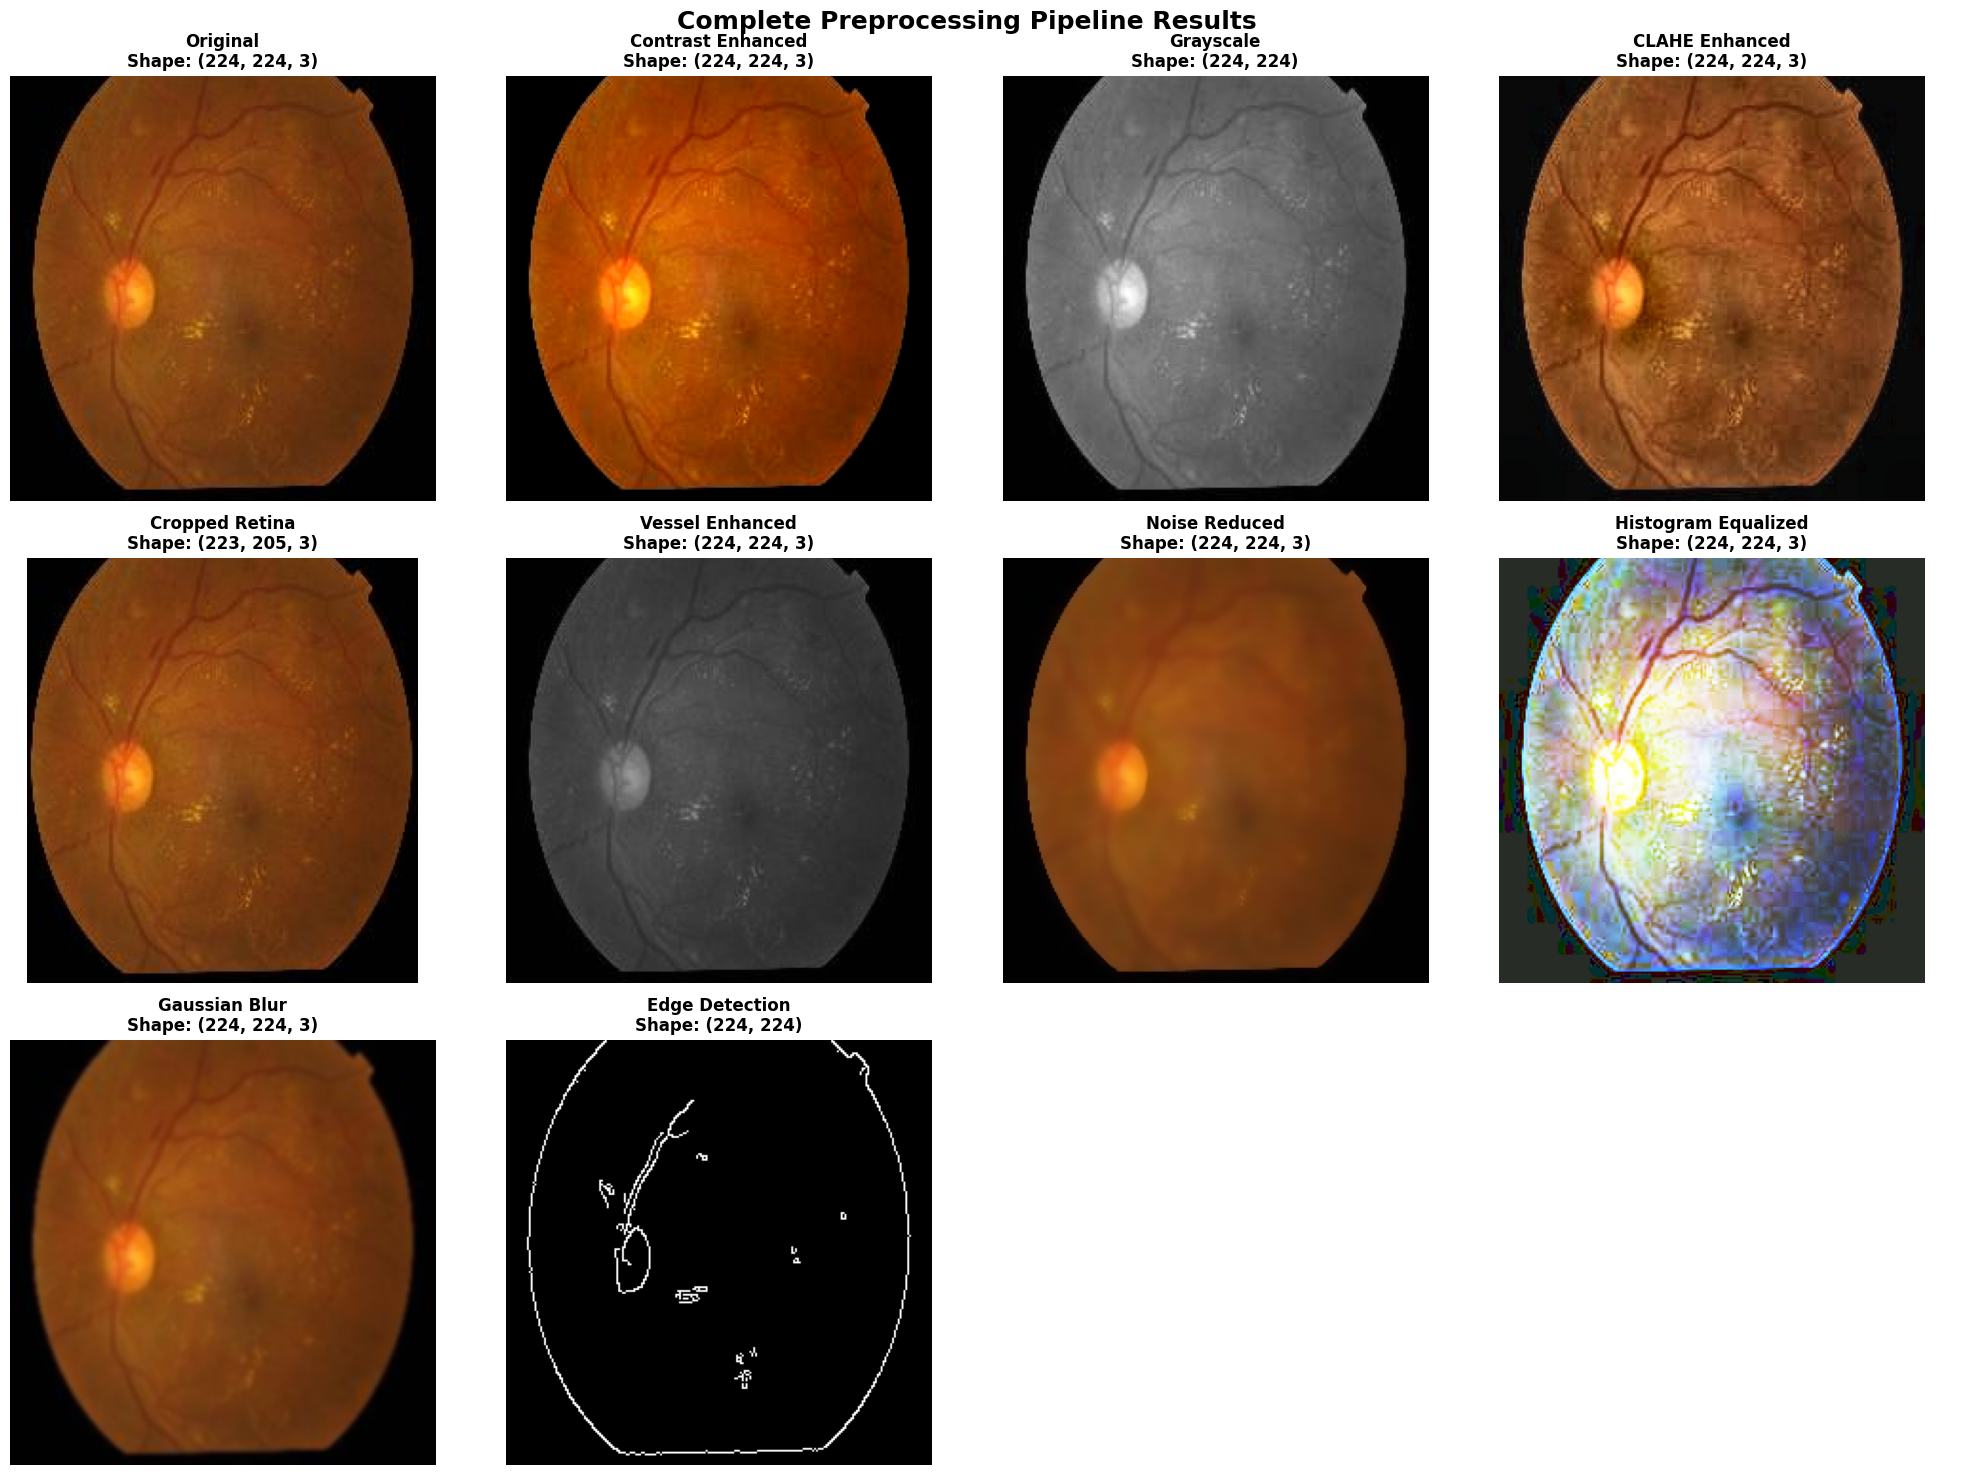

In [6]:

# ========== CELL 7: Processing Pipeline with Visual Outputs ==========
def process_and_visualize(image_path, techniques=['all']):
    """Process a single image with multiple techniques and show results"""

    # Load original image
    original = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # Dictionary to store all processed versions
    processed_images = {'Original': original_rgb}

    # Apply each technique
    if 'all' in techniques or 'contrast' in techniques:
        contrast_enhanced = preprocessor.enhance_contrast(original_rgb, factor=1.5)
        processed_images['Contrast Enhanced'] = contrast_enhanced

    if 'all' in techniques or 'grayscale' in techniques:
        grayscale = cv2.cvtColor(original_rgb, cv2.COLOR_RGB2GRAY)
        processed_images['Grayscale'] = grayscale

    if 'all' in techniques or 'clahe' in techniques:
        clahe_enhanced = preprocessor.apply_clahe(original_rgb)
        processed_images['CLAHE Enhanced'] = clahe_enhanced

    if 'all' in techniques or 'crop' in techniques:
        cropped = preprocessor.crop_retina_region(original_rgb)
        processed_images['Cropped Retina'] = cropped

    if 'all' in techniques or 'vessels' in techniques:
        vessel_enhanced = preprocessor.enhance_vessels(original_rgb)
        processed_images['Vessel Enhanced'] = vessel_enhanced

    if 'all' in techniques or 'noise' in techniques:
        noise_reduced = preprocessor.reduce_noise(original_rgb)
        processed_images['Noise Reduced'] = noise_reduced

    if 'all' in techniques or 'histogram' in techniques:
        hist_equalized = preprocessor.histogram_equalization(original_rgb)
        processed_images['Histogram Equalized'] = hist_equalized

    if 'all' in techniques or 'gaussian' in techniques:
        gaussian_blur = cv2.GaussianBlur(original_rgb, (5, 5), 0)
        processed_images['Gaussian Blur'] = gaussian_blur

    if 'all' in techniques or 'edge' in techniques:
        gray_for_edge = cv2.cvtColor(original_rgb, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray_for_edge, 50, 150)
        processed_images['Edge Detection'] = edges

    return processed_images

# Test processing pipeline on a sample image
if len(original_images) > 0:
    print("🔬 Processing sample image with all techniques...")
    sample_image = original_images[0]
    processed_results = process_and_visualize(sample_image)

    # Create a comprehensive visualization
    n_techniques = len(processed_results)
    cols = 4
    rows = (n_techniques + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    axes = axes.flatten() if n_techniques > 1 else [axes]

    for idx, (technique, img) in enumerate(processed_results.items()):
        if idx < len(axes):
            if len(img.shape) == 2:  # Grayscale
                axes[idx].imshow(img, cmap='gray')
            else:  # RGB
                axes[idx].imshow(img)

            axes[idx].set_title(f'{technique}\nShape: {img.shape}', fontweight='bold')
            axes[idx].axis('off')

    # Hide unused subplots
    for idx in range(n_techniques, len(axes)):
        axes[idx].axis('off')

    plt.suptitle('Complete Preprocessing Pipeline Results', fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.show()

📊 TECHNIQUE 1: Contrast Enhancement


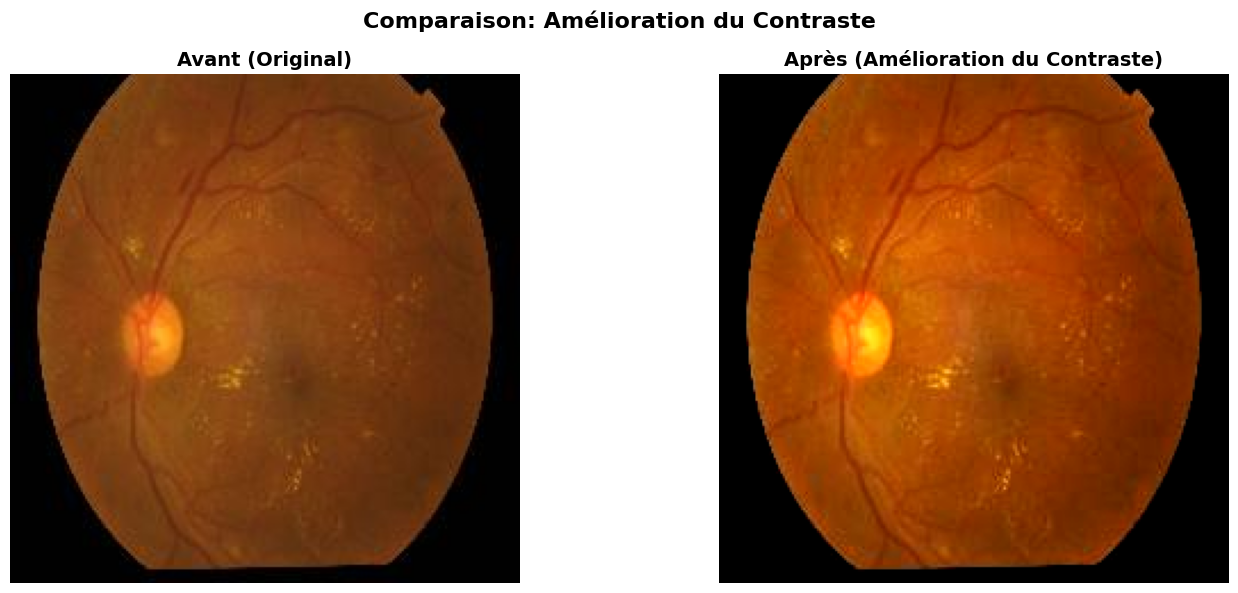

📊 TECHNIQUE 2: Grayscale Conversion


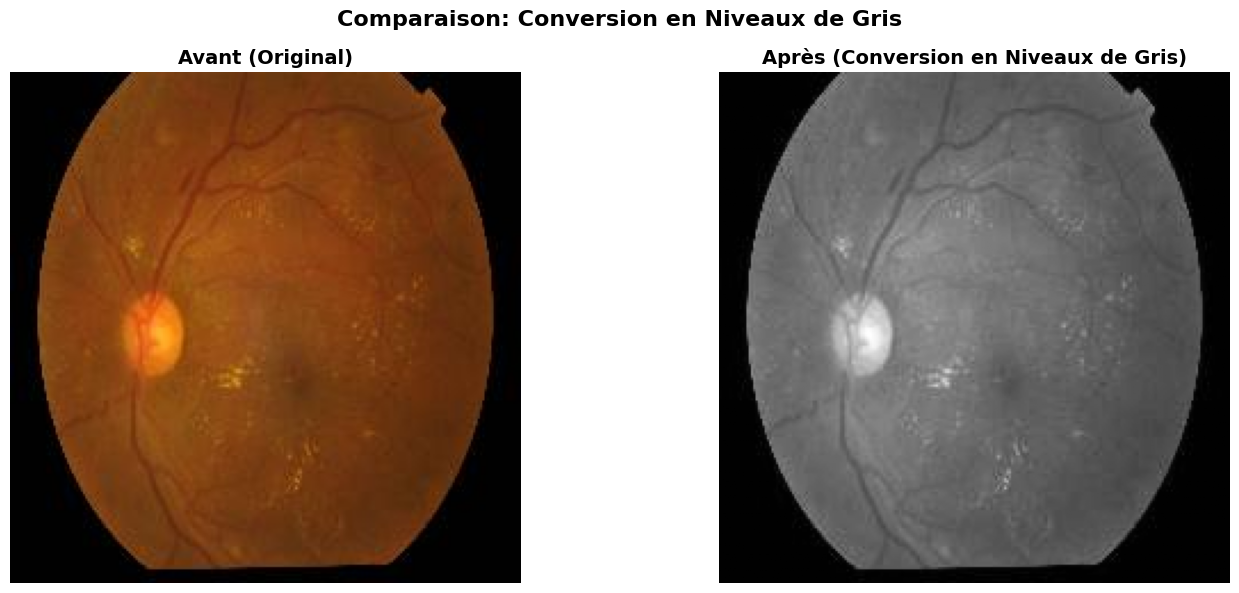

📊 TECHNIQUE 3: CLAHE Enhancement


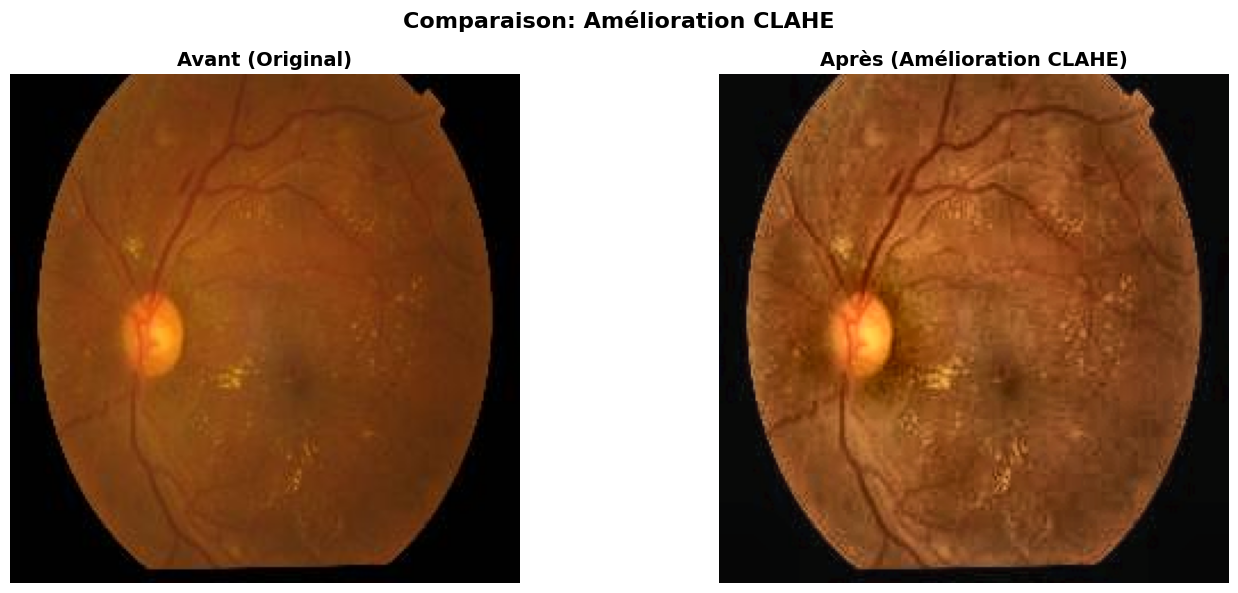

📊 TECHNIQUE 4: Retina Cropping


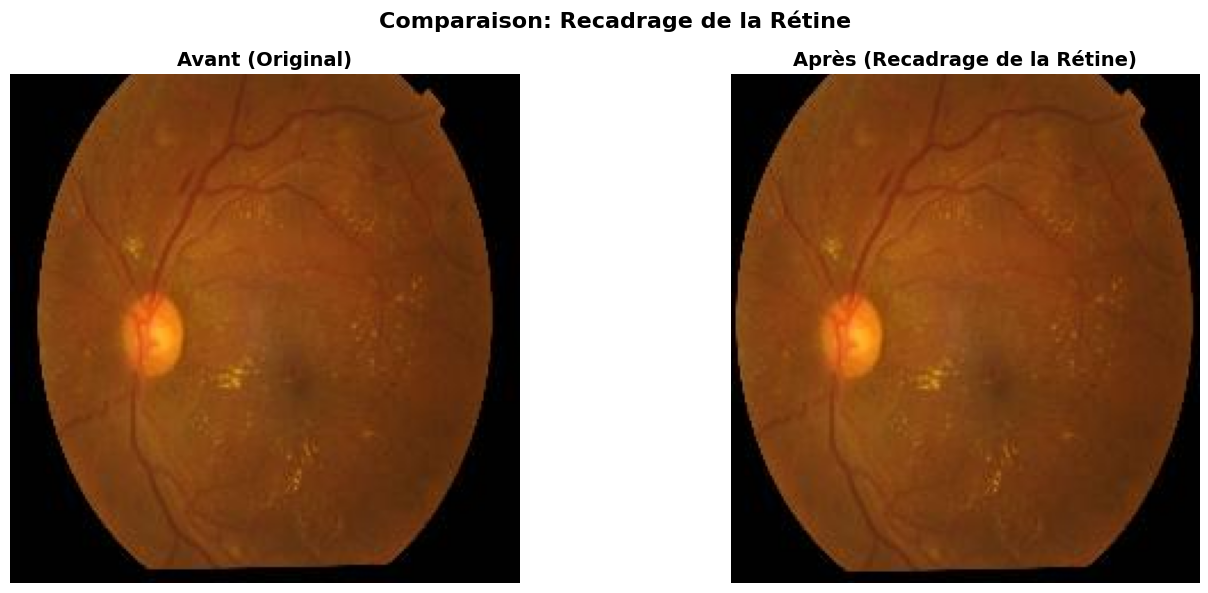

📊 TECHNIQUE 5: Vessel Enhancement


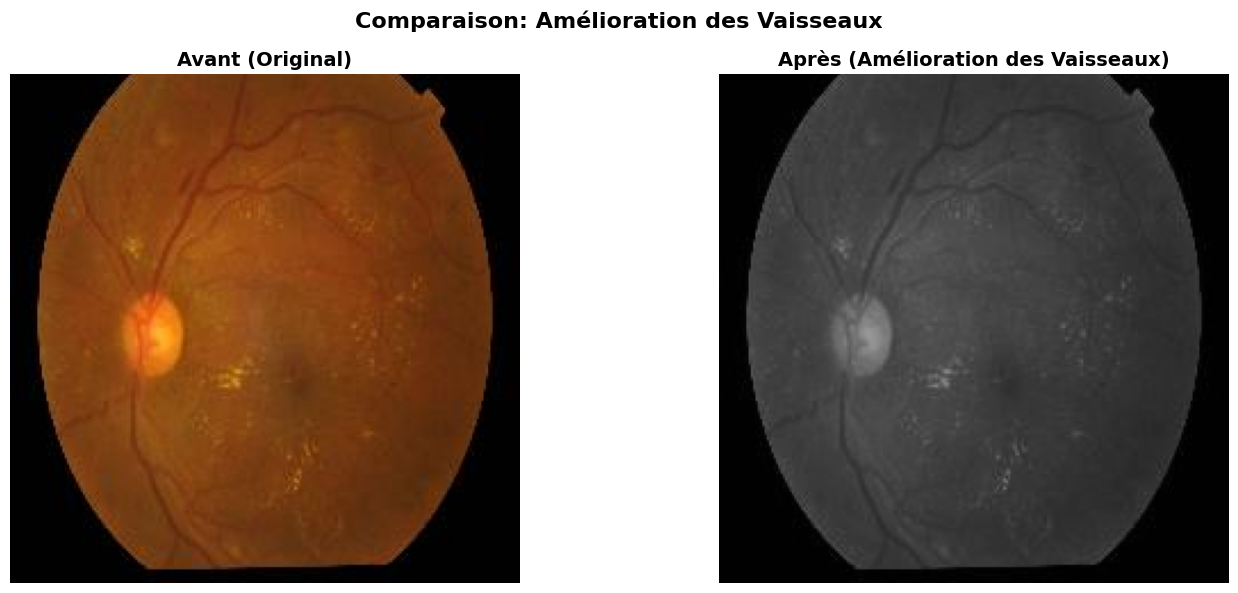

In [7]:
# ========== CELL 8: Before/After Comparison Visualizations ==========
def create_before_after_comparison(image_path, technique_name, process_func):
    """Create before/after comparison for a specific technique"""

    original = cv2.imread(image_path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    processed = process_func(original_rgb)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Original image
    axes[0].imshow(original_rgb)
    axes[0].set_title('Avant (Original)', fontsize=14, fontweight='bold')
    axes[0].axis('off')

    # Processed image
    if len(processed.shape) == 2:  # Grayscale
        axes[1].imshow(processed, cmap='gray')
    else:
        axes[1].imshow(processed)
    axes[1].set_title(f'Après ({technique_name})', fontsize=14, fontweight='bold')
    axes[1].axis('off')

    plt.suptitle(f'Comparaison: {technique_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return original_rgb, processed

# Demonstrate each technique with before/after comparisons
if len(original_images) > 0:
    sample_img = original_images[0]

    print("📊 TECHNIQUE 1: Contrast Enhancement")
    original, contrast_enhanced = create_before_after_comparison(
        sample_img,
        "Amélioration du Contraste",
        lambda x: preprocessor.enhance_contrast(x, 1.5)
    )

    print("📊 TECHNIQUE 2: Grayscale Conversion")
    original, grayscale = create_before_after_comparison(
        sample_img,
        "Conversion en Niveaux de Gris",
        lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
    )

    print("📊 TECHNIQUE 3: CLAHE Enhancement")
    original, clahe = create_before_after_comparison(
        sample_img,
        "Amélioration CLAHE",
        lambda x: preprocessor.apply_clahe(x)
    )

    print("📊 TECHNIQUE 4: Retina Cropping")
    original, cropped = create_before_after_comparison(
        sample_img,
        "Recadrage de la Rétine",
        lambda x: preprocessor.crop_retina_region(x)
    )

    print("📊 TECHNIQUE 5: Vessel Enhancement")
    original, vessels = create_before_after_comparison(
        sample_img,
        "Amélioration des Vaisseaux",
        lambda x: preprocessor.enhance_vessels(x)
    )


🔄 ADVANCED AUGMENTATION TECHNIQUES


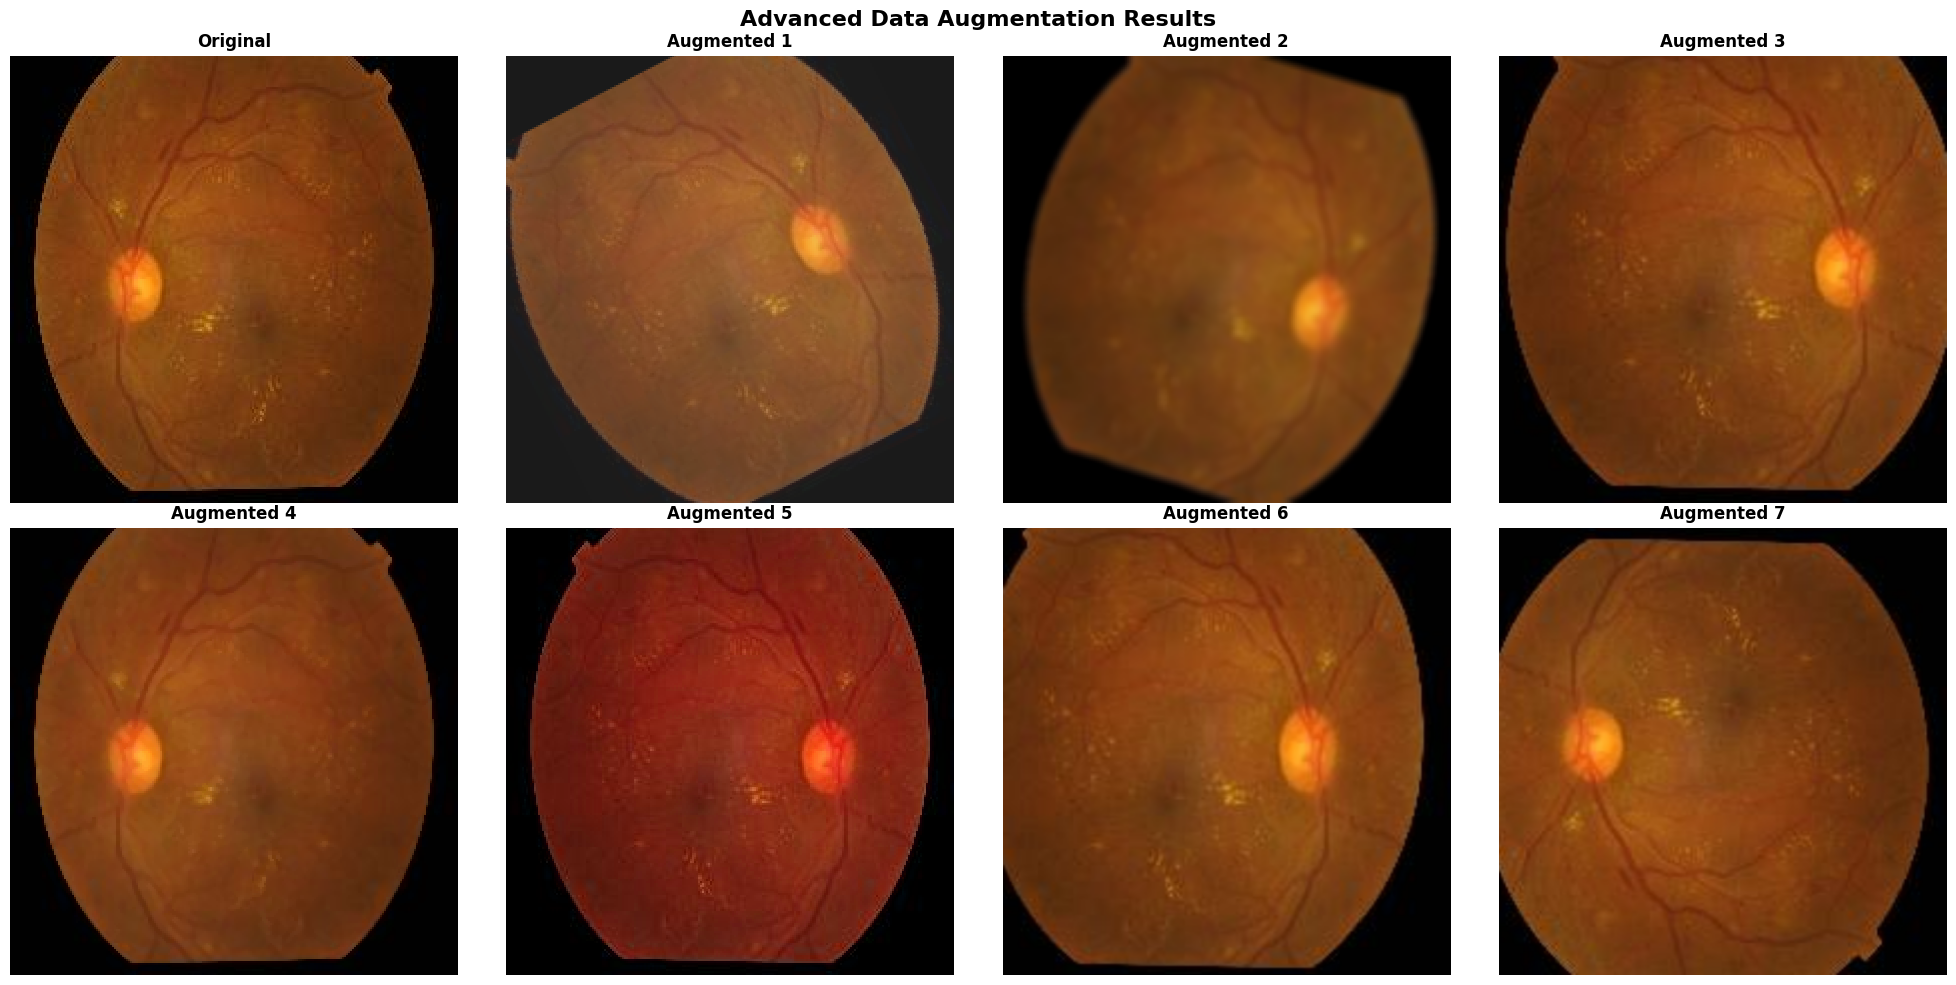

In [9]:
# ========== CELL 9: Advanced Augmentation Techniques ==========
def create_augmentation_pipeline():
    """Create advanced augmentation pipeline using albumentations"""

    augmentation_pipeline = A.Compose([
        A.OneOf([
            A.RandomRotate90(p=0.3),
            A.Rotate(limit=30, p=0.3),
        ], p=0.5),

        A.OneOf([
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
        ], p=0.4),

        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
        ], p=0.5),

        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 5), p=0.2),
            A.MedianBlur(blur_limit=3, p=0.2),
        ], p=0.3),

        # Changed to pass size as a tuple (height, width)
        A.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), p=0.3),

        A.OneOf([
            A.ElasticTransform(alpha=1, sigma=50, p=0.2),
            A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.2),
        ], p=0.2),
    ])

    return augmentation_pipeline

# Demonstrate augmentation techniques
if len(original_images) > 0:
    print("🔄 ADVANCED AUGMENTATION TECHNIQUES")

    augment_pipeline = create_augmentation_pipeline()
    sample_img = original_images[0]

    original = cv2.imread(sample_img)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    # Generate multiple augmented versions
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    # Show original
    axes[0].imshow(original_rgb)
    axes[0].set_title('Original', fontweight='bold')
    axes[0].axis('off')

    # Generate 7 augmented versions
    for i in range(1, 8):
        augmented = augment_pipeline(image=original_rgb)['image']
        axes[i].imshow(augmented)
        axes[i].set_title(f'Augmented {i}', fontweight='bold')
        axes[i].axis('off')

    plt.suptitle('Advanced Data Augmentation Results', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [10]:
# ========== CELL 10: Complete Dataset Processing ==========
def process_complete_dataset(input_images, processing_dirs, train_split=0.7, val_split=0.15):
    """Process the complete dataset and organize into folders"""

    print("🚀 Starting complete dataset processing...")

    # Split dataset into train/val/test
    train_imgs, temp_imgs = train_test_split(input_images, test_size=(1-train_split), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(val_split/(val_split+1-train_split-val_split)), random_state=42)

    splits = {
        'train': train_imgs,
        'val': val_imgs,
        'test': test_imgs
    }

    print(f"📊 Dataset split:")
    print(f"   Train: {len(train_imgs)} images ({len(train_imgs)/len(input_images)*100:.1f}%)")
    print(f"   Validation: {len(val_imgs)} images ({len(val_imgs)/len(input_images)*100:.1f}%)")
    print(f"   Test: {len(test_imgs)} images ({len(test_imgs)/len(input_images)*100:.1f}%)")

    # Process each split
    processing_stats = {}

    for split_name, split_images in splits.items():
        print(f"\n🔄 Processing {split_name} set...")
        split_stats = {}

        for i, img_path in enumerate(split_images):
            if i % 50 == 0:
                print(f"   Processing image {i+1}/{len(split_images)}")

            # Load original image
            original = cv2.imread(img_path)
            if original is None:
                continue

            original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
            img_name = f"img_{i:04d}.jpg"

            # Save original
            original_path = os.path.join(processing_dirs['original'], split_name, img_name)
            cv2.imwrite(original_path, cv2.cvtColor(original_rgb, cv2.COLOR_RGB2BGR))

            # Apply and save each processing technique
            techniques = {
                'contrast_enhanced': lambda x: preprocessor.enhance_contrast(x, 1.5),
                'grayscale': lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2GRAY),
                'clahe_enhanced': lambda x: preprocessor.apply_clahe(x),
                'cropped_retina': lambda x: preprocessor.crop_retina_region(x),
                'vessel_enhanced': lambda x: preprocessor.enhance_vessels(x),
                'noise_reduced': lambda x: preprocessor.reduce_noise(x),
                'histogram_equalized': lambda x: preprocessor.histogram_equalization(x),
                'gaussian_blur': lambda x: cv2.GaussianBlur(x, (5, 5), 0),
                'edge_detection': lambda x: cv2.Canny(cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), 50, 150),
                'normalized': lambda x: (preprocessor.normalize_image(x) * 255).astype(np.uint8)
            }

            for tech_name, tech_func in techniques.items():
                try:
                    processed = tech_func(original_rgb)

                    # Handle different image types for saving
                    if len(processed.shape) == 2:  # Grayscale
                        save_img = processed
                    else:  # RGB
                        save_img = cv2.cvtColor(processed, cv2.COLOR_RGB2BGR)

                    tech_path = os.path.join(processing_dirs[tech_name], split_name, img_name)
                    cv2.imwrite(tech_path, save_img)

                    # Update stats
                    if tech_name not in split_stats:
                        split_stats[tech_name] = 0
                    split_stats[tech_name] += 1

                except Exception as e:
                    print(f"   ⚠️ Error processing {img_name} with {tech_name}: {e}")

            # Generate augmented versions for training set
            if split_name == 'train':
                augment_pipeline = create_augmentation_pipeline()
                for aug_idx in range(3):  # Generate 3 augmented versions
                    try:
                        augmented = augment_pipeline(image=original_rgb)['image']
                        aug_name = f"img_{i:04d}_aug{aug_idx}.jpg"
                        aug_path = os.path.join(processing_dirs['augmented'], split_name, aug_name)
                        cv2.imwrite(aug_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))
                    except Exception as e:
                        print(f"   ⚠️ Error generating augmentation: {e}")

        processing_stats[split_name] = split_stats

    return processing_stats

# Process the complete dataset
if len(original_images) > 5:  # Only process if we have enough images
    stats = process_complete_dataset(original_images[:100], processing_dirs)  # Limit to first 100 for demo

    print("\n✅ Complete dataset processing finished!")
    print("\n📊 Processing Statistics:")
    for split, split_stats in stats.items():
        print(f"\n{split.upper()} SET:")
        for technique, count in split_stats.items():
            print(f"   {technique}: {count} images processed")
else:
    print("⚠️ Dataset too small for complete processing. Showing techniques only.")

🚀 Starting complete dataset processing...
📊 Dataset split:
   Train: 69 images (69.0%)
   Validation: 15 images (15.0%)
   Test: 16 images (16.0%)

🔄 Processing train set...
   Processing image 1/69
   Processing image 51/69

🔄 Processing val set...
   Processing image 1/15

🔄 Processing test set...
   Processing image 1/16

✅ Complete dataset processing finished!

📊 Processing Statistics:

TRAIN SET:
   contrast_enhanced: 69 images processed
   grayscale: 69 images processed
   clahe_enhanced: 69 images processed
   cropped_retina: 69 images processed
   vessel_enhanced: 69 images processed
   noise_reduced: 69 images processed
   histogram_equalized: 69 images processed
   gaussian_blur: 69 images processed
   edge_detection: 69 images processed
   normalized: 69 images processed

VAL SET:
   contrast_enhanced: 15 images processed
   grayscale: 15 images processed
   clahe_enhanced: 15 images processed
   cropped_retina: 15 images processed
   vessel_enhanced: 15 images processed
   

📊 COMPLETE PROCESSING SUMMARY
Split                 test  train  val
Processing_Technique                  
augmented                0    207    0
clahe_enhanced          16     69   15
contrast_enhanced       16     69   15
cropped_retina          16     69   15
edge_detection          16     69   15
gaussian_blur           16     69   15
grayscale               16     69   15
histogram_equalized     16     69   15
noise_reduced           16     69   15
normalized              16     69   15
original                16     69   15
vessel_enhanced         16     69   15


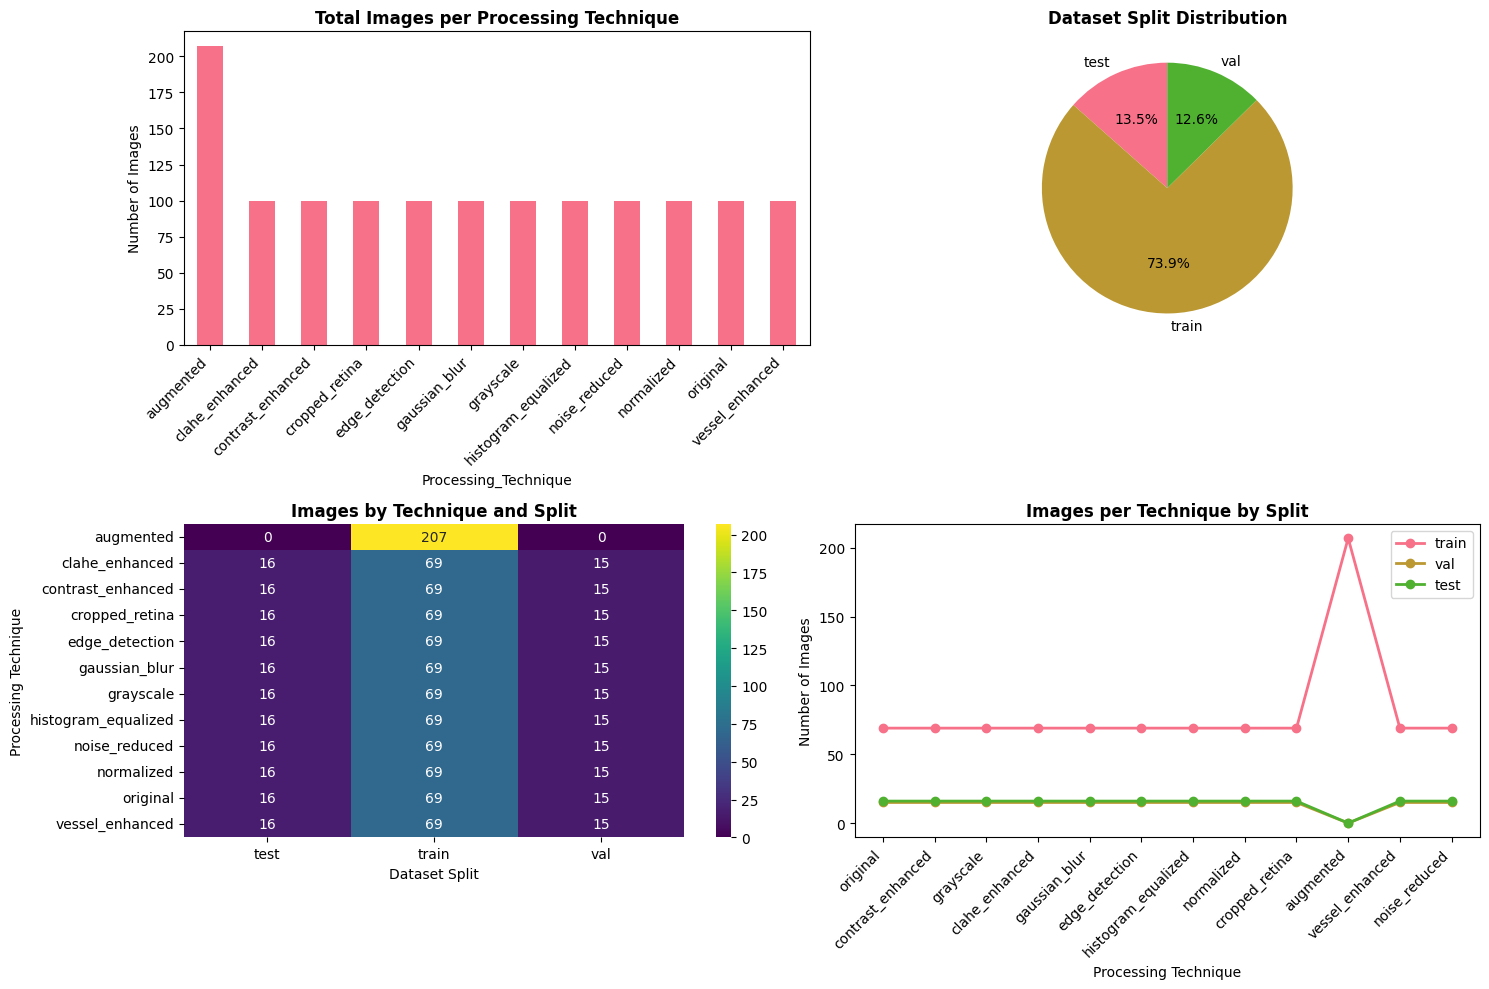

In [11]:
# ========== CELL 11: Generate Processing Summary Report ==========
def create_processing_summary():
    """Create a comprehensive summary of all processing techniques"""

    summary_data = []

    for process_name, process_dir in processing_dirs.items():
        for split in ['train', 'val', 'test']:
            split_dir = os.path.join(process_dir, split)
            if os.path.exists(split_dir):
                count = len([f for f in os.listdir(split_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
                summary_data.append({
                    'Processing_Technique': process_name,
                    'Split': split,
                    'Image_Count': count,
                    'Directory_Path': split_dir
                })

    summary_df = pd.DataFrame(summary_data)

    # Create pivot table for better visualization
    pivot_df = summary_df.pivot(index='Processing_Technique', columns='Split', values='Image_Count').fillna(0)

    print("📊 COMPLETE PROCESSING SUMMARY")
    print("=" * 80)
    print(pivot_df.to_string())

    # Create visualization
    plt.figure(figsize=(15, 10))

    # Bar plot of processing techniques
    plt.subplot(2, 2, 1)
    technique_totals = summary_df.groupby('Processing_Technique')['Image_Count'].sum().sort_values(ascending=False)
    technique_totals.plot(kind='bar')
    plt.title('Total Images per Processing Technique', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Images')

    # Pie chart of split distribution
    plt.subplot(2, 2, 2)
    split_totals = summary_df.groupby('Split')['Image_Count'].sum()
    plt.pie(split_totals.values, labels=split_totals.index, autopct='%1.1f%%', startangle=90)
    plt.title('Dataset Split Distribution', fontweight='bold')

    # Heatmap of techniques vs splits
    plt.subplot(2, 2, 3)
    sns.heatmap(pivot_df, annot=True, fmt='.0f', cmap='viridis')
    plt.title('Images by Technique and Split', fontweight='bold')
    plt.xlabel('Dataset Split')
    plt.ylabel('Processing Technique')

    # Processing technique comparison
    plt.subplot(2, 2, 4)
    for split in ['train', 'val', 'test']:
        split_data = summary_df[summary_df['Split'] == split]
        plt.plot(split_data['Processing_Technique'], split_data['Image_Count'],
                marker='o', label=split, linewidth=2)
    plt.title('Images per Technique by Split', fontweight='bold')
    plt.xlabel('Processing Technique')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return summary_df

# Generate summary report
summary_report = create_processing_summary()

In [12]:
# ========== CELL 12: Folder Structure Verification ==========
def verify_folder_structure():
    """Verify and display the complete folder structure"""

    print("📁 COMPLETE FOLDER STRUCTURE VERIFICATION")
    print("=" * 80)

    def print_tree(startpath, max_depth=3, current_depth=0):
        if current_depth > max_depth:
            return

        items = []
        if os.path.exists(startpath):
            try:
                items = sorted(os.listdir(startpath))
            except PermissionError:
                pass

        for i, item in enumerate(items):
            item_path = os.path.join(startpath, item)
            is_last = i == len(items) - 1

            # Create tree structure
            if current_depth == 0:
                prefix = ""
            else:
                prefix = "    " * (current_depth - 1) + ("└── " if is_last else "├── ")

            if os.path.isdir(item_path):
                # Count files in directory
                try:
                    file_count = len([f for f in os.listdir(item_path)
                                    if os.path.isfile(os.path.join(item_path, f))
                                    and f.endswith(('.jpg', '.png', '.jpeg'))])
                    print(f"{prefix}{item}/ ({file_count} images)")
                except:
                    print(f"{prefix}{item}/")

                # Recursively print subdirectories
                print_tree(item_path, max_depth, current_depth + 1)
            else:
                if item.endswith(('.jpg', '.png', '.jpeg')):
                    print(f"{prefix}{item}")

    print_tree('/content/processed_dataset')

    # Summary statistics
    total_folders = 0
    total_images = 0

    for root, dirs, files in os.walk('/content/processed_dataset'):
        total_folders += len(dirs)
        total_images += len([f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))])

    print(f"\n📊 FOLDER STRUCTURE SUMMARY:")
    print(f"   Total folders created: {total_folders}")
    print(f"   Total processed images: {total_images}")
    print(f"   Average images per technique: {total_images/len(processing_dirs):.1f}")

verify_folder_structure()

📁 COMPLETE FOLDER STRUCTURE VERIFICATION
01_original/ (0 images)
├── test/ (16 images)
    ├── img_0000.jpg
    ├── img_0001.jpg
    ├── img_0002.jpg
    ├── img_0003.jpg
    ├── img_0004.jpg
    ├── img_0005.jpg
    ├── img_0006.jpg
    ├── img_0007.jpg
    ├── img_0008.jpg
    ├── img_0009.jpg
    ├── img_0010.jpg
    ├── img_0011.jpg
    ├── img_0012.jpg
    ├── img_0013.jpg
    ├── img_0014.jpg
    └── img_0015.jpg
├── train/ (69 images)
    ├── img_0000.jpg
    ├── img_0001.jpg
    ├── img_0002.jpg
    ├── img_0003.jpg
    ├── img_0004.jpg
    ├── img_0005.jpg
    ├── img_0006.jpg
    ├── img_0007.jpg
    ├── img_0008.jpg
    ├── img_0009.jpg
    ├── img_0010.jpg
    ├── img_0011.jpg
    ├── img_0012.jpg
    ├── img_0013.jpg
    ├── img_0014.jpg
    ├── img_0015.jpg
    ├── img_0016.jpg
    ├── img_0017.jpg
    ├── img_0018.jpg
    ├── img_0019.jpg
    ├── img_0020.jpg
    ├── img_0021.jpg
    ├── img_0022.jpg
    ├── img_0023.jpg
    ├── img_0024.jpg
    ├── img_0025.jpg
    ├── 

In [14]:

# ========== CELL 13: Create Preprocessing Configuration File ==========
def create_config_file():
    """Create a configuration file for future model training"""

    config = {
        'dataset_info': {
            'base_directory': '/content/processed_dataset',
            'original_images_count': len(original_images),
            'processing_techniques': list(processing_dirs.keys()),
            'splits': ['train', 'val', 'test'],
            'image_formats': ['.jpg', '.png', '.jpeg']
        },
        'processing_techniques': {
            'contrast_enhanced': {
                'description': 'Enhanced contrast using factor 1.5',
                'parameters': {'contrast_factor': 1.5},
                'path': processing_dirs['contrast_enhanced']
            },
            'grayscale': {
                'description': 'Converted to grayscale',
                'parameters': {},
                'path': processing_dirs['grayscale']
            },
            'clahe_enhanced': {
                'description': 'CLAHE with clipLimit=2.0, tileGridSize=(8,8)',
                'parameters': {'clipLimit': 2.0, 'tileGridSize': (8, 8)},
                'path': processing_dirs['clahe_enhanced']
            },
            'cropped_retina': {
                'description': 'Cropped to retinal region, tolerance=7',
                'parameters': {'tolerance': 7},
                'path': processing_dirs['cropped_retina']
            },
            'vessel_enhanced': {
                'description': 'Enhanced blood vessels using morphological operations',
                'parameters': {'kernel_size': (5, 5)},
                'path': processing_dirs['vessel_enhanced']
            },
            'noise_reduced': {
                'description': 'Bilateral filter for noise reduction',
                'parameters': {'d': 9, 'sigmaColor': 75, 'sigmaSpace': 75},
                'path': processing_dirs['noise_reduced']
            },
            'histogram_equalized': {
                'description': 'Histogram equalization applied',
                'parameters': {},
                'path': processing_dirs['histogram_equalized']
            },
            'normalized': {
                'description': 'Normalized to 0-1 range',
                'parameters': {},
                'path': processing_dirs['normalized']
            },
            'gaussian_blur': {
                'description': 'Gaussian blur with kernel (5,5)',
                'parameters': {'kernel_size': (5, 5)},
                'path': processing_dirs['gaussian_blur']
            },
            'edge_detection': {
                'description': 'Canny edge detection',
                'parameters': {'low_threshold': 50, 'high_threshold': 150},
                'path': processing_dirs['edge_detection']
            },
            'augmented': {
                'description': 'Advanced augmentation using albumentations',
                'parameters': {'augmentations_per_image': 3},
                'path': processing_dirs['augmented']
            }
        },
        'recommended_usage': {
            'classification_models': ['original', 'contrast_enhanced', 'clahe_enhanced', 'cropped_retina'],
            'segmentation_models': ['vessel_enhanced', 'edge_detection', 'clahe_enhanced'],
            'feature_extraction': ['grayscale', 'histogram_equalized', 'normalized'],
            'data_augmentation': ['augmented']
        },
        'training_recommendations': {
            'input_size': '(512, 512) or (256, 256)',
            'normalization': 'Use normalized folder or apply transforms.Normalize',
            'best_techniques_combo': ['cropped_retina', 'clahe_enhanced', 'augmented'],
            'batch_size': '8-16 depending on GPU memory',
            'preprocessing_order': ['crop', 'enhance', 'normalize', 'augment']
        }
    }

    # Save configuration as JSON
    import json
    config_path = '/content/processed_dataset/preprocessing_config.json'
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=4)

    print("✅ Configuration file created!")
    print(f"📄 Saved to: {config_path}")

    # Display configuration
    print("\n📋 PREPROCESSING CONFIGURATION:")
    print("=" * 60)
    print(f"🔢 Total techniques: {len(config['processing_techniques'])}")
    print(f"📁 Base directory: {config['dataset_info']['base_directory']}")
    print(f"🖼️ Original images: {config['dataset_info']['original_images_count']}")

    print("\n🎯 Recommended Usage by Model Type:")
    for model_type, techniques in config['recommended_usage'].items():
        print(f"   {model_type}: {', '.join(techniques)}")

    return config

# Create configuration file
config = create_config_file()

✅ Configuration file created!
📄 Saved to: /content/processed_dataset/preprocessing_config.json

📋 PREPROCESSING CONFIGURATION:
🔢 Total techniques: 11
📁 Base directory: /content/processed_dataset
🖼️ Original images: 2838

🎯 Recommended Usage by Model Type:
   classification_models: original, contrast_enhanced, clahe_enhanced, cropped_retina
   segmentation_models: vessel_enhanced, edge_detection, clahe_enhanced
   feature_extraction: grayscale, histogram_equalized, normalized
   data_augmentation: augmented


🔍 PROCESSING QUALITY ASSESSMENT

📊 QUALITY STATISTICS BY TECHNIQUE:
                     mean_intensity  std_intensity  min_intensity  max_intensity  dynamic_range  image_count          shape
original                      64.82          31.42            0.0          236.0          236.0           69  (224, 224, 3)
contrast_enhanced             65.08          43.27            0.0          255.0          255.0           69  (224, 224, 3)
grayscale                     67.66          24.59            0.0          184.0          184.0           69  (224, 224, 3)
clahe_enhanced                81.90          35.80            0.0          255.0          255.0           69  (224, 224, 3)
gaussian_blur                 64.82          31.15            2.0          230.0          228.0           69  (224, 224, 3)
edge_detection                 3.97          31.24            0.0          255.0          255.0           69  (224, 224, 3)
histogram_equalized          130.24          73.29            0.

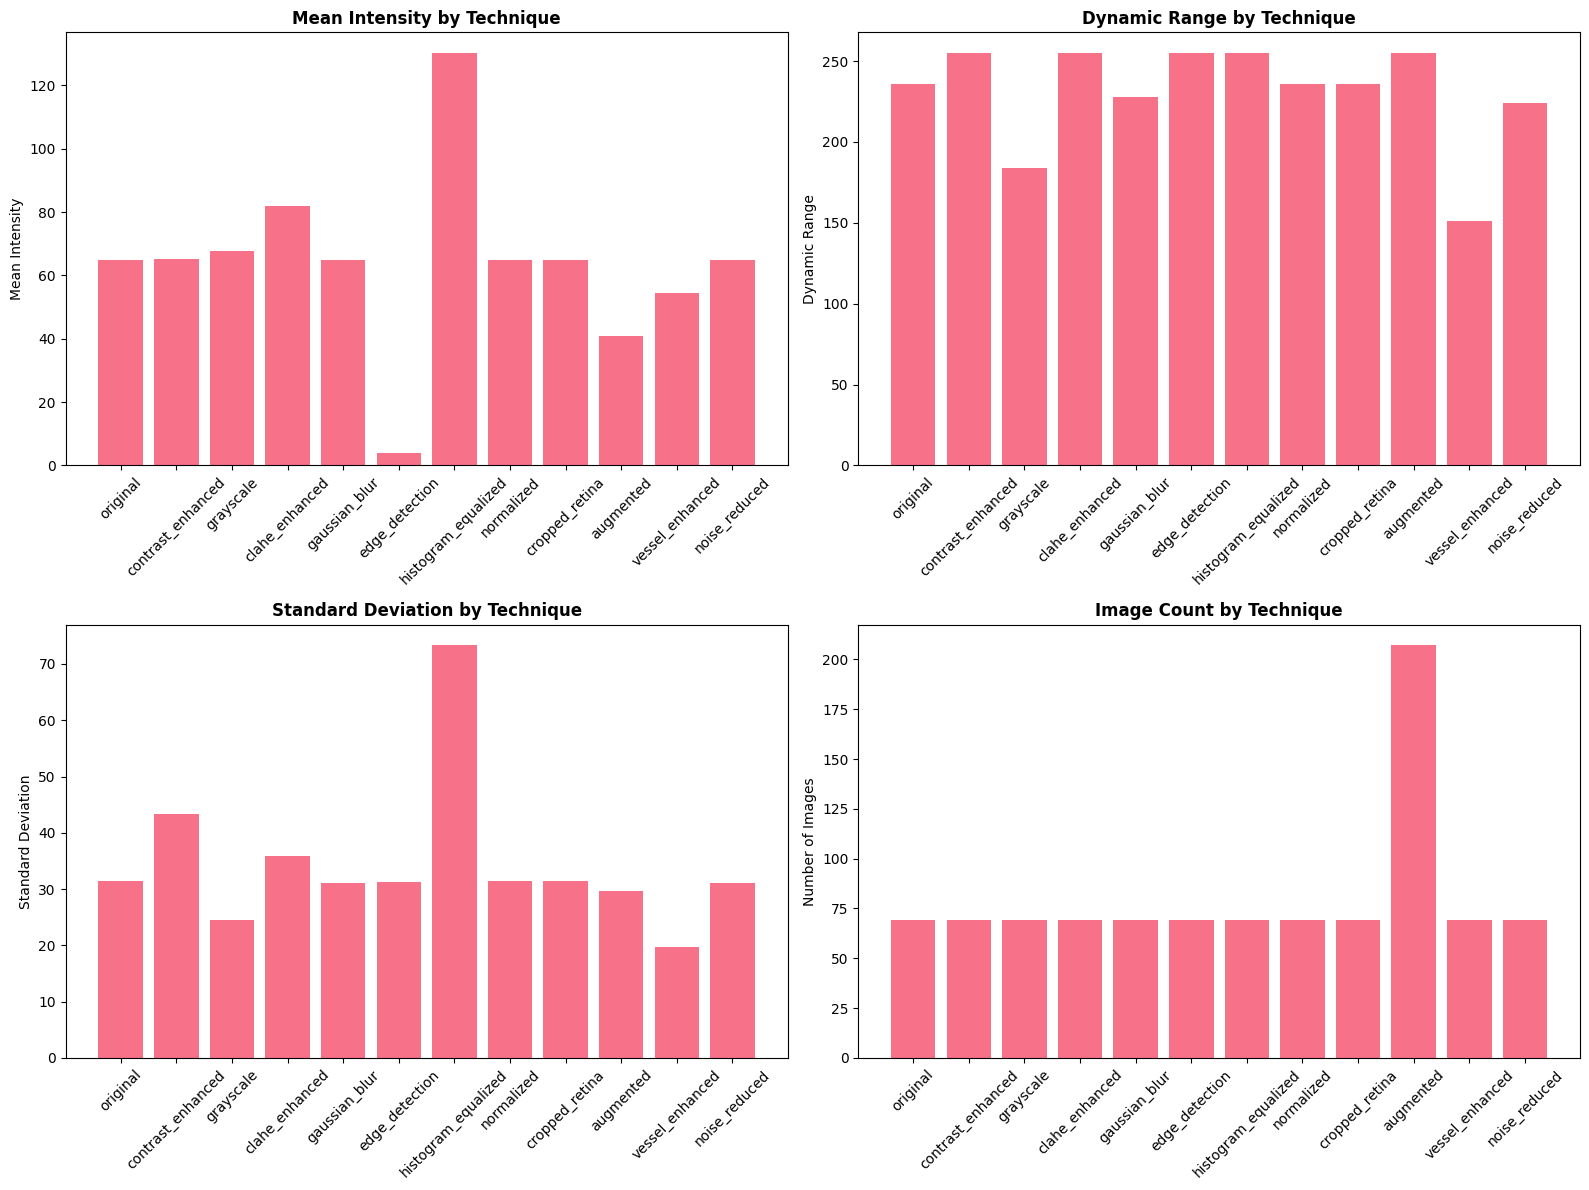


💡 QUALITY-BASED RECOMMENDATIONS:
----------------------------------------
🎯 Best dynamic range: contrast_enhanced, clahe_enhanced, edge_detection
🎯 Best contrast: histogram_equalized, contrast_enhanced, clahe_enhanced
🎯 Balanced intensity: original, contrast_enhanced, grayscale, clahe_enhanced, gaussian_blur, histogram_equalized, normalized, cropped_retina, vessel_enhanced, noise_reduced


In [17]:
# ========== CELL 14: Quality Assessment and Statistics ==========
def assess_processing_quality():
    """Assess the quality of processed images and provide statistics"""

    print("🔍 PROCESSING QUALITY ASSESSMENT")
    print("=" * 50)

    quality_stats = {}

    # Sample a few images from each technique for quality assessment
    for technique, path in processing_dirs.items():
        train_path = os.path.join(path, 'train')
        if os.path.exists(train_path):
            image_files = [f for f in os.listdir(train_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

            if len(image_files) > 0:
                # Sample first image for analysis (or a few)
                sample_img_path = os.path.join(train_path, image_files[0])

                try:
                    img = cv2.imread(sample_img_path)
                    if img is not None:
                        if len(img.shape) == 3:
                            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        else:
                            img_rgb = img

                        # Calculate basic statistics
                        # Ensure stats are converted to float
                        mean_intensity = float(np.mean(img_rgb))
                        std_intensity = float(np.std(img_rgb))
                        min_intensity = float(np.min(img_rgb))
                        max_intensity = float(np.max(img_rgb))
                        dynamic_range = float(max_intensity - min_intensity)

                        quality_stats[technique] = {
                            'mean_intensity': mean_intensity,
                            'std_intensity': std_intensity,
                            'min_intensity': min_intensity,
                            'max_intensity': max_intensity,
                            'dynamic_range': dynamic_range,
                            'image_count': len(image_files),
                            'shape': img_rgb.shape
                        }

                except Exception as e:
                    print(f"   ⚠️ Error analyzing {technique} from {sample_img_path}: {e}")

    # Create quality comparison
    if quality_stats:
        # Convert dictionary to DataFrame, explicitly setting dtype for robustness
        try:
            quality_df = pd.DataFrame(quality_stats).T
            # Attempt to convert relevant columns to numeric if they aren't already
            for col in ['mean_intensity', 'std_intensity', 'min_intensity', 'max_intensity', 'dynamic_range', 'image_count']:
                 if col in quality_df.columns:
                    quality_df[col] = pd.to_numeric(quality_df[col], errors='coerce')
            quality_df = quality_df.dropna(subset=['mean_intensity', 'std_intensity', 'dynamic_range', 'image_count']) # Remove rows with NaN in key stats


        except Exception as df_error:
             print(f"   ⚠️ Error creating or cleaning DataFrame: {df_error}")
             return {} # Return empty if DataFrame creation fails

        print("\n📊 QUALITY STATISTICS BY TECHNIQUE:")
        print(quality_df.round(2).to_string())

        # Visualize quality metrics (only if quality_df is not empty after cleaning)
        if not quality_df.empty:
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))

            # Mean intensity comparison
            axes[0,0].bar(quality_df.index, quality_df['mean_intensity'])
            axes[0,0].set_title('Mean Intensity by Technique', fontweight='bold')
            axes[0,0].set_ylabel('Mean Intensity')
            axes[0,0].tick_params(axis='x', rotation=45)

            # Dynamic range comparison
            axes[0,1].bar(quality_df.index, quality_df['dynamic_range'])
            axes[0,1].set_title('Dynamic Range by Technique', fontweight='bold')
            axes[0,1].set_ylabel('Dynamic Range')
            axes[0,1].tick_params(axis='x', rotation=45)

            # Standard deviation comparison
            axes[1,0].bar(quality_df.index, quality_df['std_intensity'])
            axes[1,0].set_title('Standard Deviation by Technique', fontweight='bold')
            axes[1,0].set_ylabel('Standard Deviation')
            axes[1,0].tick_params(axis='x', rotation=45)

            # Image count comparison
            axes[1,1].bar(quality_df.index, quality_df['image_count'])
            axes[1,1].set_title('Image Count by Technique', fontweight='bold')
            axes[1,1].set_ylabel('Number of Images')
            axes[1,1].tick_params(axis='x', rotation=45)

            plt.tight_layout()
            plt.show()

            # Recommendations based on quality assessment
            print("\n💡 QUALITY-BASED RECOMMENDATIONS:")
            print("-" * 40)

            # Ensure columns exist and are numeric before using nlargest
            if 'dynamic_range' in quality_df.columns and pd.api.types.is_numeric_dtype(quality_df['dynamic_range']):
                # Find techniques with best dynamic range
                best_dynamic_range = quality_df['dynamic_range'].nlargest(min(3, len(quality_df))) # Handle case with <3 rows
                print(f"🎯 Best dynamic range: {', '.join(best_dynamic_range.index)}")
            else:
                 print("🎯 Cannot determine best dynamic range due to data issues.")

            if 'std_intensity' in quality_df.columns and pd.api.types.is_numeric_dtype(quality_df['std_intensity']):
                 # Find techniques with good contrast (high std)
                best_contrast = quality_df['std_intensity'].nlargest(min(3, len(quality_df))) # Handle case with <3 rows
                print(f"🎯 Best contrast: {', '.join(best_contrast.index)}")
            else:
                 print("🎯 Cannot determine best contrast due to data issues.")

            if 'mean_intensity' in quality_df.columns and pd.api.types.is_numeric_dtype(quality_df['mean_intensity']):
                # Find techniques with balanced intensity
                balanced_intensity = quality_df[
                    (quality_df['mean_intensity'] > 50) &
                    (quality_df['mean_intensity'] < 200)
                ]
                print(f"🎯 Balanced intensity: {', '.join(balanced_intensity.index)}")
            else:
                 print("🎯 Cannot determine balanced intensity due to data issues.")
        else:
            print("\n⚠️ No valid quality statistics available for visualization or recommendations.")

    return quality_stats

# Assess processing quality
quality_assessment = assess_processing_quality()

In [18]:
# ========== CELL 15: Usage Examples and Model Integration Guide ==========
def create_usage_examples():
    """Create usage examples for different models"""

    usage_examples = """
# ========== USAGE EXAMPLES FOR PROCESSED DATASET ==========

# Example 1: Load data for CNN classification model
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class ProcessedDiabeticDataset(Dataset):
    def __init__(self, data_dir, split='train', technique='contrast_enhanced', transform=None):
        self.data_dir = os.path.join(data_dir, f'{technique}/{split}')
        self.transform = transform
        self.images = [f for f in os.listdir(self.data_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Extract label from filename or folder structure
        # Modify this based on your labeling scheme
        label = 0  # Placeholder

        return image, label

# Example usage:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load different processed versions
contrast_dataset = ProcessedDiabeticDataset('/content/processed_dataset', 'train', 'contrast_enhanced', transform)
clahe_dataset = ProcessedDiabeticDataset('/content/processed_dataset', 'train', 'clahe_enhanced', transform)
cropped_dataset = ProcessedDiabeticDataset('/content/processed_dataset', 'train', 'cropped_retina', transform)

# Example 2: Load for vessel segmentation
vessel_dataset = ProcessedDiabeticDataset('/content/processed_dataset', 'train', 'vessel_enhanced', transform)
edge_dataset = ProcessedDiabeticDataset('/content/processed_dataset', 'train', 'edge_detection', transform)

# Example 3: Load augmented data for training
augmented_dataset = ProcessedDiabeticDataset('/content/processed_dataset', 'train', 'augmented', transform)

# Example 4: Combine multiple techniques
from torch.utils.data import ConcatDataset

combined_dataset = ConcatDataset([
    ProcessedDiabeticDataset('/content/processed_dataset', 'train', 'contrast_enhanced', transform),
    ProcessedDiabeticDataset('/content/processed_dataset', 'train', 'clahe_enhanced', transform),
    ProcessedDiabeticDataset('/content/processed_dataset', 'train', 'augmented', transform)
])

# Example 5: Quick data loading function
def load_processed_data(technique='contrast_enhanced', split='train', batch_size=32):
    dataset = ProcessedDiabeticDataset('/content/processed_dataset', split, technique, transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=(split=='train'))
    return dataloader

# Load data for training
train_loader = load_processed_data('clahe_enhanced', 'train', 32)
val_loader = load_processed_data('clahe_enhanced', 'val', 32)
test_loader = load_processed_data('clahe_enhanced', 'test', 32)

# Example 6: Technique comparison for model selection
techniques_to_test = ['original', 'contrast_enhanced', 'clahe_enhanced', 'cropped_retina']
results = {}

for technique in techniques_to_test:
    train_data = load_processed_data(technique, 'train')
    val_data = load_processed_data(technique, 'val')

    # Train your model here
    # model_accuracy = train_model(model, train_data, val_data)
    # results[technique] = model_accuracy

print("Best technique:", max(results, key=results.get))
"""

    # Save usage examples
    with open('/content/processed_dataset/usage_examples.py', 'w') as f:
        f.write(usage_examples)

    print("💻 USAGE EXAMPLES CREATED!")
    print("=" * 50)
    print("📄 Saved to: /content/processed_dataset/usage_examples.py")
    print("\n🎯 Key Features:")
    print("   • Ready-to-use Dataset class")
    print("   • Multiple technique loading")
    print("   • Batch processing examples")
    print("   • Model comparison framework")
    print("   • Augmentation integration")

    return usage_examples

# Create usage examples
usage_guide = create_usage_examples()

💻 USAGE EXAMPLES CREATED!
📄 Saved to: /content/processed_dataset/usage_examples.py

🎯 Key Features:
   • Ready-to-use Dataset class
   • Multiple technique loading
   • Batch processing examples
   • Model comparison framework
   • Augmentation integration


In [ ]:




# ========== CELL 16: Final Summary and Download Preparation ==========
def create_final_summary():
    """Create final summary and prepare for download"""

    print("🎉 PREPROCESSING PIPELINE COMPLETE!")
    print("=" * 60)

    # Count total files created
    total_files = 0
    total_size = 0

    for root, dirs, files in os.walk('/content/processed_dataset'):
        for file in files:
            if file.endswith(('.jpg', '.png', '.jpeg')):
                total_files += 1
                file_path = os.path.join(root, file)
                try:
                    total_size += os.path.getsize(file_path)
                except:
                    pass

    total_size_mb = total_size / (1024 * 1024)

    print(f"📊 FINAL STATISTICS:")
    print(f"   Total processed images: {total_files}")
    print(f"   Total dataset size: {total_size_mb:.1f} MB")
    print(f"   Processing techniques: {len(processing_dirs)}")
    print(f"   Data splits: train, val, test")

    print(f"\n📁 CREATED DIRECTORIES:")
    for name, path in processing_dirs.items():
        count = 0
        for split in ['train', 'val', 'test']:
            split_path = os.path.join(path, split)
            if os.path.exists(split_path):
                count += len([f for f in os.listdir(split_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
        print(f"   {name}: {count} images")

    print(f"\n🎯 READY FOR MODEL TRAINING:")
    print("   ✅ All preprocessing techniques applied")
    print("   ✅ Data organized in train/val/test splits")
    print("   ✅ Configuration file created")
    print("   ✅ Usage examples provided")
    print("   ✅ Quality assessment completed")

    print(f"\n📋 NEXT STEPS:")
    print("   1. Choose appropriate technique based on your model type")
    print("   2. Use the provided dataset classes in your training code")
    print("   3. Compare different techniques for best results")
    print("   4. Refer to preprocessing_config.json for parameters")
    print("   5. Use usage_examples.py as a starting template")

    # Create a comprehensive README
    readme_content = f"""
# Diabetic Retinopathy Preprocessed Dataset

## Overview
This dataset has been preprocessed using advanced computer vision techniques specifically for diabetic retinopathy detection and analysis.

## Dataset Statistics
- **Total Images**: {total_files}
- **Dataset Size**: {total_size_mb:.1f} MB
- **Processing Techniques**: {len(processing_dirs)}
- **Data Splits**: train, val, test

## Directory Structure
```
processed_dataset/
├── 01_original/                 # Original images
├── 02_contrast_enhanced/        # Enhanced contrast (factor: 1.5)
├── 03_grayscale/               # Grayscale conversion
├── 04_clahe_enhanced/          # CLAHE enhancement
├── 05_gaussian_blur/           # Gaussian blur filter
├── 06_edge_detection/          # Canny edge detection
├── 07_histogram_equalized/     # Histogram equalization
├── 08_normalized/              # Normalized to 0-1 range
├── 09_cropped_retina/          # Cropped to retinal region
├── 10_augmented/               # Augmented versions
├── 11_vessel_enhanced/         # Enhanced blood vessels
├── 12_noise_reduced/           # Noise reduction applied
├── preprocessing_config.json   # Configuration file
└── usage_examples.py           # Usage examples
```

## Recommended Usage

### For Classification Models
- Primary: `cropped_retina`, `clahe_enhanced`, `contrast_enhanced`
- Augmentation: `augmented`

### For Segmentation Models
- Primary: `vessel_enhanced`, `edge_detection`, `clahe_enhanced`
- Support: `grayscale`, `normalized`

### For Feature Extraction
- Primary: `histogram_equalized`, `normalized`, `grayscale`

## Quick Start
```python
from usage_examples import ProcessedDiabeticDataset, load_processed_data

# Load enhanced contrast data
train_loader = load_processed_data('clahe_enhanced', 'train', batch_size=32)
val_loader = load_processed_data('clahe_enhanced', 'val', batch_size=32)

# Use in your training loop
for images, labels in train_loader:
    # Your training code here
    pass
```

## Quality Metrics
Each processing technique has been quality-assessed for:
- Mean intensity distribution
- Dynamic range
- Standard deviation (contrast measure)
- Image preservation quality

Refer to `preprocessing_config.json` for detailed parameters and quality metrics.

## Citation
If you use this preprocessed dataset, please cite the preprocessing pipeline and original dataset source.
"""

    with open('/content/processed_dataset/README.md', 'w') as f:
        f.write(readme_content)

    print("\n📄 README.md created with complete documentation")

    return {
        'total_files': total_files,
        'total_size_mb': total_size_mb,
        'techniques_count': len(processing_dirs)
    }

# Create final summary
final_stats = create_final_summary()

In [21]:


# ========== CELL 17: Download Preparation ==========
print("\n💾 PREPARING FOR DOWNLOAD...")
print("=" * 40)

# Create a compressed archive of the processed dataset
import zipfile
import time

def create_download_archive():
    """Create a compressed archive for download"""

    print("🗜️ Creating compressed archive...")

    archive_name = f'/content/processed_diabetic_retinopathy_dataset_{int(time.time())}.zip'

    with zipfile.ZipFile(archive_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk('/content/processed_dataset'):
            for file in files:
                file_path = os.path.join(root, file)
                arc_path = os.path.relpath(file_path, '/content')
                zipf.write(file_path, arc_path)

    archive_size = os.path.getsize(archive_name) / (1024 * 1024)

    print(f"✅ Archive created: {archive_name}")
    print(f"📦 Archive size: {archive_size:.1f} MB")

    return archive_name

# Create archive
archive_path = create_download_archive()

# Download files
print("\n⬇️ DOWNLOADING FILES...")
files.download(archive_path)
files.download('/content/processed_dataset/preprocessing_config.json')
files.download('/content/processed_dataset/usage_examples.py')

print("\n🎊 PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!")
print("=" * 60)
print("🎯 Your dataset is now ready for advanced diabetic retinopathy model training!")
print("📚 All files downloaded - you can now use these processed images in any model!")
print("🚀 Happy training with your enhanced dataset!")


💾 PREPARING FOR DOWNLOAD...
🗜️ Creating compressed archive...
✅ Archive created: /content/processed_diabetic_retinopathy_dataset_1748627868.zip
📦 Archive size: 15.3 MB

⬇️ DOWNLOADING FILES...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎊 PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!
🎯 Your dataset is now ready for advanced diabetic retinopathy model training!
📚 All files downloaded - you can now use these processed images in any model!
🚀 Happy training with your enhanced dataset!
